<a href="https://colab.research.google.com/github/nikbizkit/MMO/blob/main/Lb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №2 по курсу "Методы машинного обучения"
Выполнил: Гудилин Д.С. группа ИУ5-24М
Задание
Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
1. масштабирование признаков (не менее чем тремя способами);
2. обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
3. обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
4. отбор признаков:
один метод из группы методов фильтрации (filter methods);
один метод из группы методов обертывания (wrapper methods);
один метод из группы методов вложений (embedded methods).

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import scipy.stats as stats
import six
import sys
from sklearn.impute import SimpleImputer
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')




In [39]:
data = pd.read_csv('data.csv')
data.head()


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


Масштабирование признаков


In [40]:
data['R_Height_cms'].describe()

count    6008.000000
mean      178.991788
std         8.812985
min       152.400000
25%       172.720000
50%       180.340000
75%       185.420000
max       210.820000
Name: R_Height_cms, dtype: float64

In [41]:
minMaxScaler = MinMaxScaler()
data['R_Height_cms_minmax'] = minMaxScaler.fit_transform(data[['R_Height_cms']])
data['R_Height_cms_minmax'].describe()

count    6008.000000
mean        0.455183
std         0.150856
min         0.000000
25%         0.347826
50%         0.478261
75%         0.565217
max         1.000000
Name: R_Height_cms_minmax, dtype: float64

In [42]:
standardScaler = StandardScaler()
data['R_Height_cms_standard'] = standardScaler.fit_transform(data[['R_Height_cms']])
data['R_Height_cms_standard'].describe()


count    6.008000e+03
mean     4.444680e-17
std      1.000083e+00
min     -3.017593e+00
25%     -7.117123e-01
50%      1.529930e-01
75%      7.294631e-01
max      3.611814e+00
Name: R_Height_cms_standard, dtype: float64

In [43]:
robustScaler = RobustScaler()
data['R_Height_cms_robust'] = robustScaler.fit_transform(data[['R_Height_cms']])
data['R_Height_cms_robust'].describe()

count    6008.000000
mean       -0.106158
std         0.693936
min        -2.200000
25%        -0.600000
50%         0.000000
75%         0.400000
max         2.400000
Name: R_Height_cms_robust, dtype: float64

Обработка выбросов

In [44]:
def diagnostic_plots(df, variable):
 fig, ax = plt.subplots(figsize=(20,10))
 plt.subplot(2, 2, 1)
 sns.kdeplot(data=data, x=variable)
 ## Q-Q plot
 plt.subplot(2, 2, 2)
 stats.probplot(df[variable], dist="norm", plot=plt)
 # ящик с усами
 plt.subplot(2, 2, 3)
 sns.boxplot(x=df[variable])
 # ящик с усами
 plt.subplot(2, 2, 4)
 df[variable].hist(bins=30)
 plt.show()


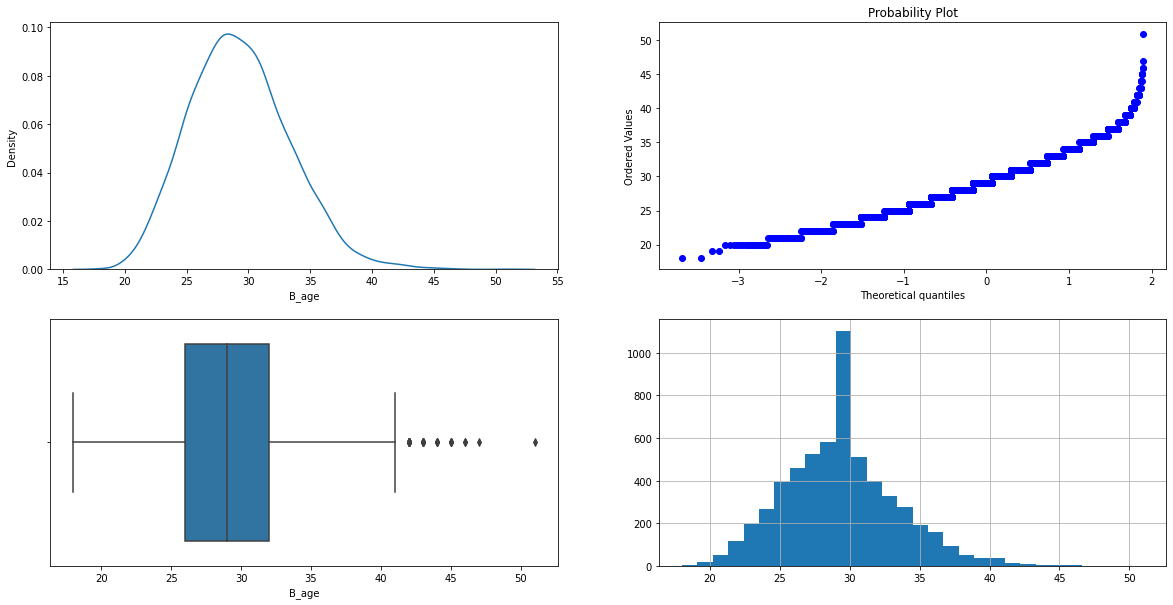

In [45]:
diagnostic_plots(data, 'B_age')


In [46]:
outlierBoundaryType = {
 'SIGMA': 1,
 'QUANTILE': 2,
 'IRQ': 3
}


In [47]:
def get_outlier_boundaries(df, col, outlier_boundary_type):
 if outlier_boundary_type == outlierBoundaryType['SIGMA']:
  K1 = 3
  lower_boundary = df[col].mean() - (K1 * df[col].std())
  upper_boundary = df[col].mean() + (K1 * df[col].std())
 elif outlier_boundary_type == outlierBoundaryType['QUANTILE']:
  lower_boundary = df[col].quantile(0.05)
  upper_boundary = df[col].quantile(0.95)
 elif outlier_boundary_type == outlierBoundaryType['IRQ']:
  K2 = 1.5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
  upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
 else:
  return 0, 0
 return lower_boundary, upper_boundary

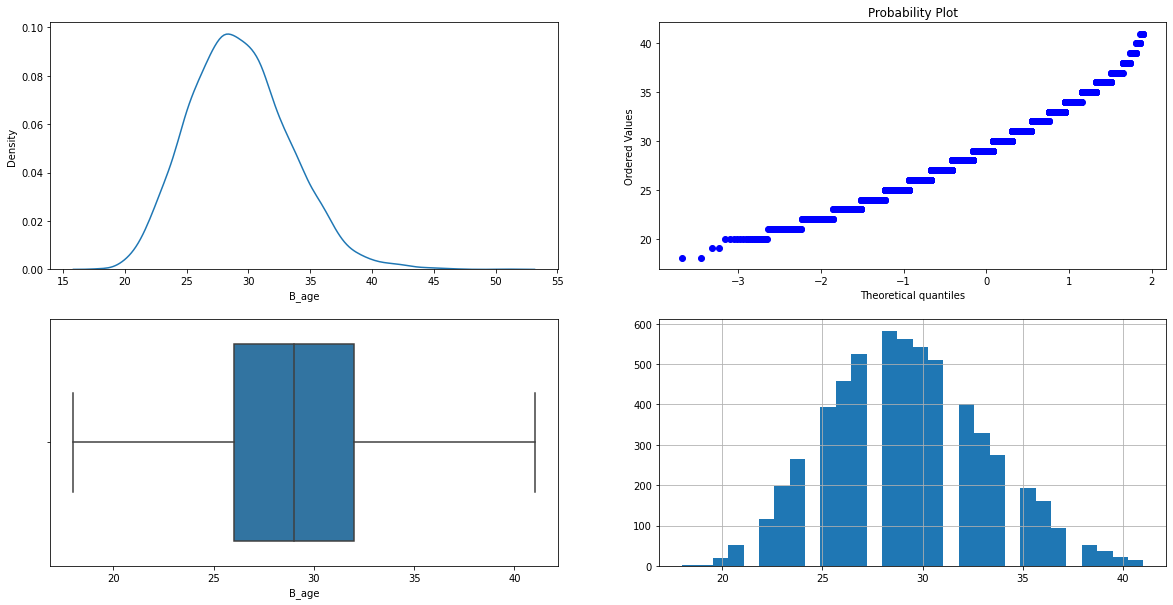

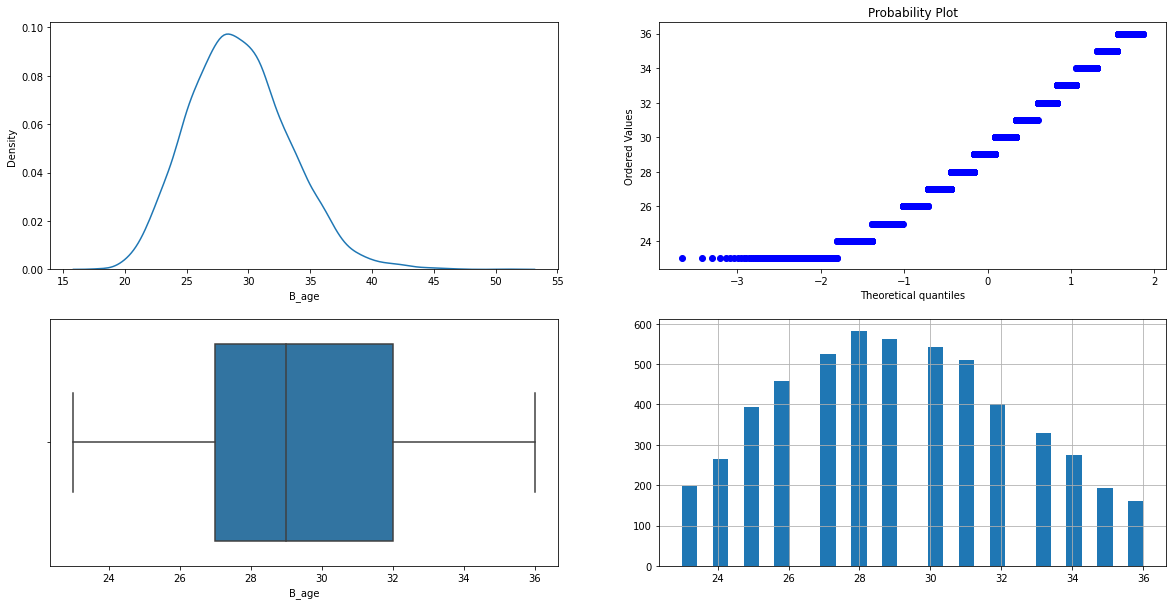

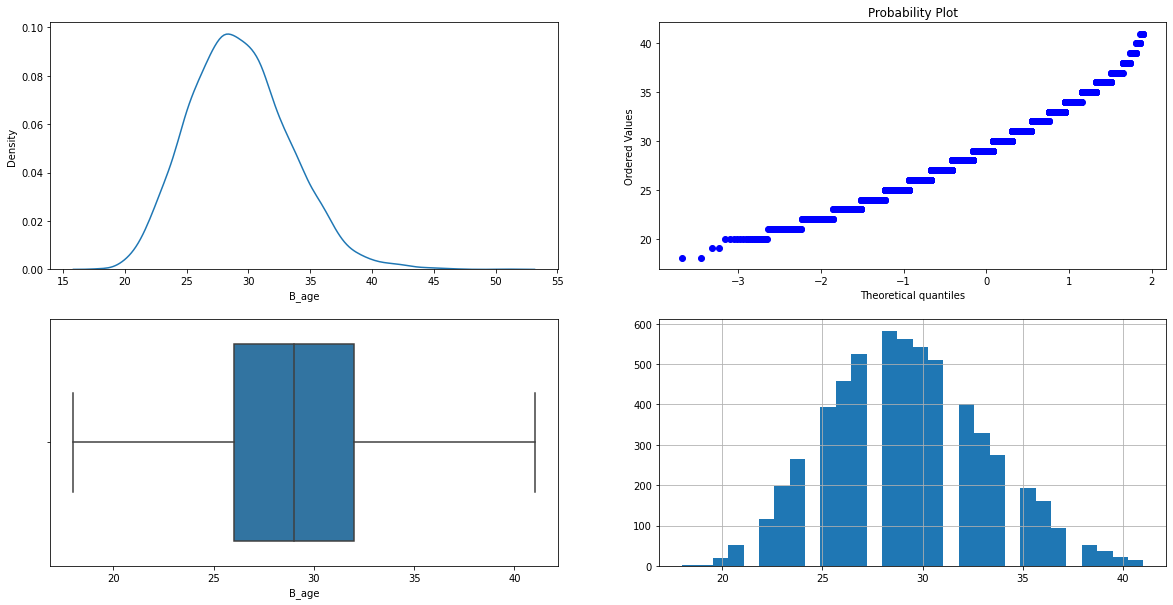

In [48]:
for key, value in outlierBoundaryType.items():
 col = 'B_age'
 lower_boundary, upper_boundary = get_outlier_boundaries(data, col, value)
 outliers_temp = np.where(data[col] > upper_boundary, True, np.where(data[col] < lower_boundary, True, False))
 data_trimmed = data.loc[~(outliers_temp), ]
 diagnostic_plots(data_trimmed, col)

Обработка нестандартного признака

In [78]:
data2 = pd.read_csv('data.csv', sep = ",")
data2.head()



,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


In [50]:
imputer = SimpleImputer(strategy="mean")
data2[['R_Height_cms']] = imputer.fit_transform(data2[['R_Height_cms']])
data2[['R_Reach_cms']] = imputer.fit_transform(data2[['R_Reach_cms']])
data2[['R_Weight_lbs']] = imputer.fit_transform(data2[['R_Weight_lbs']])
data2 = data2.drop(columns=['R_win_by_TKO_Doctor_Stoppage'])
data2.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,0,1,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,1,0,3,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,0,1,3,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,0,1,2,2,Orthodox,167.64,172.72,135.0,29.0,43.0


In [60]:

day = []
month = []
year = []
for item in data2['date']:
 year.append(int(item.split('-')[0]))
 month.append(int(item.split('-')[1]))
 day.append(int(item.split('-')[2]))
data2.insert(3, 'day1', day, allow_duplicates=False)
data2.insert(2, 'month1', month, allow_duplicates=False)
data2.insert(1, 'year1', year, allow_duplicates=False)

data2 = data2.drop(columns='date')
data2.head()


,R_fighter,year1,year_,month1,Day,day1,month_,Month,day_,day,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,2021,2021,3,2021,20,3,3,20,20,...,0,0,1,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,2021,2021,3,2021,20,3,3,20,20,...,1,0,3,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,2021,2021,3,2021,20,3,3,20,20,...,0,1,3,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,2021,2021,3,2021,20,3,3,20,20,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,2021,2021,3,2021,20,3,3,20,20,...,0,1,2,2,Orthodox,167.64,172.72,135.0,29.0,43.0


Отбор признаков по корреляции


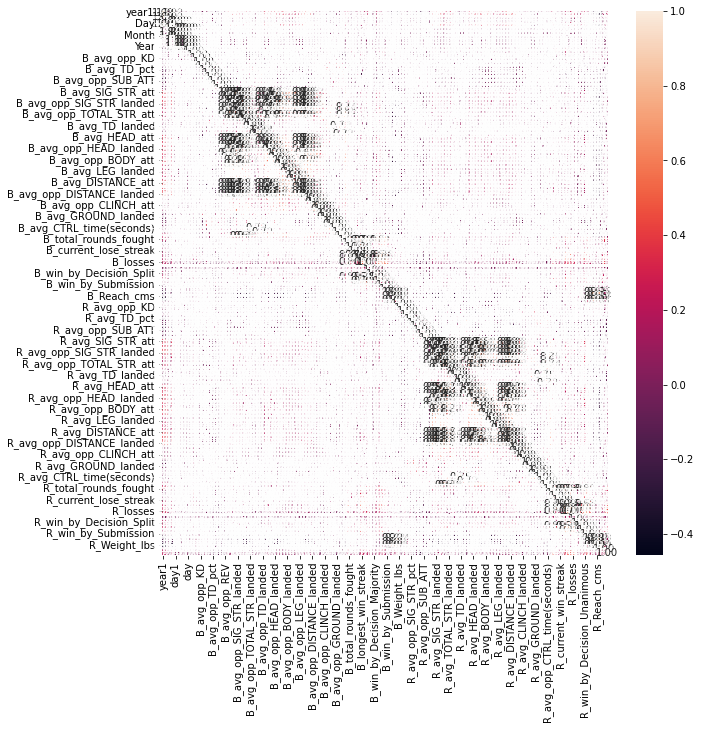

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(method='pearson'), annot=True, fmt='.2f')


In [72]:
for row in data2.corr():
 if data2.corr()[row]['R_Weight_lbs'] >= 0.8:
  print(row, data2.corr()[row]['R_Weight_lbs'])

B_Weight_lbs 0.9067894543190004
R_Weight_lbs 1.0
